In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Load measured / predicted coverages and calculate break-down of held-out gene-level performance

expr_qtls = [
    [0.0, 0.2],
    [0.2, 0.4],
    [0.4, 0.6],
    [0.6, 0.8],
    [0.8, 1.0],
]

fold_ix = 3
cross_index = [0, 1, 2, 3, -1]

mae_vals = []

#Loop over crosses
for cross_ix in cross_index :

    print("cross = " + str(cross_ix))
    
    mae_vals_fold = []
    
    #Load predictions
    df_pred = None
    if cross_ix != -1 :
        df_pred = pd.read_csv("test_apa/f" + str(fold_ix) + "c" + str(cross_ix) + "/testg-0/gene_preds.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})
    else :
        df_pred = pd.read_csv("test_apa/f" + str(fold_ix) + "c0/testg-0/gene_preds_ens.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

    #Load targets
    df_true = None
    if cross_ix != -1 :
        df_true = pd.read_csv("test_apa/f" + str(fold_ix) + "c" + str(cross_ix) + "/testg-0/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})
    else :
        df_true = pd.read_csv("test_apa/f" + str(fold_ix) + "c0/testg-0/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

    #Use all targets
    target_cols = df_pred.columns.values.tolist()[1:]
    
    df_pred = df_pred[['gene_id'] + target_cols].copy()
    df_true = df_true[['gene_id'] + target_cols].copy()
    
    print("df_pred.shape = " + str(df_pred.shape))
    print("df_true.shape = " + str(df_true.shape))
    
    y_pred = np.array(df_pred[target_cols].values, dtype='float32')
    y_true = np.array(df_true[target_cols].values, dtype='float32')
    
    num_targets_strand = y_pred.shape[1]
    
    print("num_targets_strand = " + str(num_targets_strand))
    
    #Loop over expression quantiles
    for qtl_i, [qtl_lo, qtl_hi] in enumerate(expr_qtls) :
        
        print(" - qtl range = " + str([qtl_lo, qtl_hi]))
        
        mae_val = []
        
        #Loop over targets
        for ti in range(num_targets_strand) : 
            
            y_t = y_true[:, ti]
            y_p = y_pred[:, ti]
            
            nonzero_index = np.nonzero(y_t > 0.)[0]
            
            y_t = y_t[nonzero_index]
            y_p = y_p[nonzero_index]
            
            lo_t = np.quantile(y_t, q=qtl_lo)
            hi_t = np.quantile(y_t, q=qtl_hi)
            
            #Calculate coverage mean absolute error
            keep_ixs = np.nonzero((y_t >= lo_t) & (y_t < hi_t))[0]
            
            y_t = y_t[keep_ixs]
            y_p = y_p[keep_ixs]
            
            mae_val.append(np.mean(np.abs(y_p - y_t)))
        
        mae_vals_fold.append(mae_val)
    
    mae_vals.append(mae_vals_fold)

mae_vals = np.array(mae_vals, dtype='float32')

print("mae_vals.shape = " + str(mae_vals.shape))


cross = 0
df_pred.shape = (1940, 956)
df_true.shape = (1940, 956)
num_targets_strand = 955
 - qtl range = [0.0, 0.2]
 - qtl range = [0.2, 0.4]
 - qtl range = [0.4, 0.6]
 - qtl range = [0.6, 0.8]
 - qtl range = [0.8, 1.0]
cross = 1
df_pred.shape = (1940, 956)
df_true.shape = (1940, 956)
num_targets_strand = 955
 - qtl range = [0.0, 0.2]
 - qtl range = [0.2, 0.4]
 - qtl range = [0.4, 0.6]
 - qtl range = [0.6, 0.8]
 - qtl range = [0.8, 1.0]
cross = 2
df_pred.shape = (1940, 956)
df_true.shape = (1940, 956)
num_targets_strand = 955
 - qtl range = [0.0, 0.2]
 - qtl range = [0.2, 0.4]
 - qtl range = [0.4, 0.6]
 - qtl range = [0.6, 0.8]
 - qtl range = [0.8, 1.0]
cross = 3
df_pred.shape = (1940, 956)
df_true.shape = (1940, 956)
num_targets_strand = 955
 - qtl range = [0.0, 0.2]
 - qtl range = [0.2, 0.4]
 - qtl range = [0.4, 0.6]
 - qtl range = [0.6, 0.8]
 - qtl range = [0.8, 1.0]
cross = -1
df_pred.shape = (1940, 956)
df_true.shape = (1940, 956)
num_targets_strand = 955
 - qtl range = [0.0, 0.2

In [3]:
#Load cached GTEx results

mae_vals_gtex = np.load('expr_correlation_by_expr_mae_gtex.npy')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


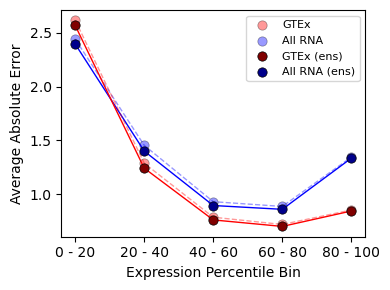

In [4]:
#Plot held-out gene-level prediction performance as a function of lowly / mid / highly expressed genes

f = plt.figure(figsize=(4, 3))

qtl_strs = [
    str(int(qtl_lo * 100)) + " - " + str(int(qtl_hi * 100))
    for [qtl_lo, qtl_hi] in expr_qtls
]

x_qtl = np.arange(len(qtl_strs))

#Per-cross performance
plt.plot(x_qtl, np.mean(mae_vals_gtex[:-1, ...], axis=(0, 2)), alpha=0.4, color='red', linewidth=1, linestyle='--', zorder=-1)
plt.scatter(x_qtl, np.mean(mae_vals_gtex[:-1, ...], axis=(0, 2)), alpha=0.4, s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(x_qtl, np.mean(mae_vals[:-1, ...], axis=(0, 2)), alpha=0.4, color='blue', linewidth=1, linestyle='--', zorder=-2)
plt.scatter(x_qtl, np.mean(mae_vals[:-1, ...], axis=(0, 2)), alpha=0.4, s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

#Ensemble performance
plt.plot(x_qtl, np.mean(mae_vals_gtex[-1:, ...], axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(x_qtl, np.mean(mae_vals_gtex[-1:, ...], axis=(0, 2)), s=45, c='maroon', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx (ens)')

plt.plot(x_qtl, np.mean(mae_vals[-1:, ...], axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(x_qtl, np.mean(mae_vals[-1:, ...], axis=(0, 2)), s=45, c='darkblue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA (ens)')

plt.xlabel("Expression Percentile Bin", fontsize=10)
plt.ylabel("Average Absolute Error", fontsize=10)

plt.xticks(x_qtl, qtl_strs, fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_v2_expr_correlation_by_expr_mae.png", dpi=300)
plt.savefig("borzoi_v2_expr_correlation_by_expr_mae.eps")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


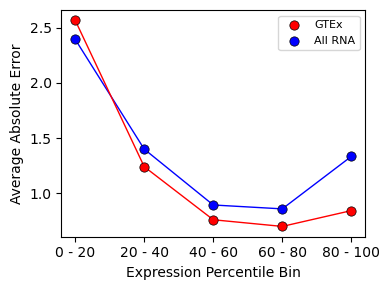

In [5]:
#Plot held-out gene-level prediction performance as a function of lowly / mid / highly expressed genes (ensemble only)

f = plt.figure(figsize=(4, 3))

qtl_strs = [
    str(int(qtl_lo * 100)) + " - " + str(int(qtl_hi * 100))
    for [qtl_lo, qtl_hi] in expr_qtls
]

x_qtl = np.arange(len(qtl_strs))

#Ensemble performance
plt.plot(x_qtl, np.mean(mae_vals_gtex[-1:, ...], axis=(0, 2)), color='red', linewidth=1, zorder=-1)
plt.scatter(x_qtl, np.mean(mae_vals_gtex[-1:, ...], axis=(0, 2)), s=45, c='red', edgecolor='black', linewidth=0.5, zorder=2, label='GTEx')

plt.plot(x_qtl, np.mean(mae_vals[-1:, ...], axis=(0, 2)), color='blue', linewidth=1, zorder=-2)
plt.scatter(x_qtl, np.mean(mae_vals[-1:, ...], axis=(0, 2)), s=45, c='blue', edgecolor='black', linewidth=0.5, zorder=1, label='All RNA')

plt.xlabel("Expression Percentile Bin", fontsize=10)
plt.ylabel("Average Absolute Error", fontsize=10)

plt.xticks(x_qtl, qtl_strs, fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig("borzoi_v2_expr_correlation_by_expr_mae_ens_only.png", dpi=300)
plt.savefig("borzoi_v2_expr_correlation_by_expr_mae_ens_only.eps")

plt.show()
